Авторы материала: аспирант Мехмата МГУ Евгений Колмаков, программист-исследователь Mail.ru Group Юрий Кашницкий.

# <center>Домашнее задание № 3. Опциональная часть 
## <center> Реализация алгоритма построения дерева решений

**Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1k4jn-czjTL_6pnQD96N3kA0uSq3cCGHcfNdKpfICURA/edit?usp=sharing).**

In [24]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.base import BaseEstimator
from sklearn.datasets import make_classification, make_regression, load_digits, load_boston
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error
from collections import Counter

Зафиксируем заранее `random_state` (a.k.a. random seed). Это должно повысить вероятность полной воспроизводимости результатов, впрочем, замечено, что тем не менее небольшие флуктуации возможны (например, качества прогнозов дерева, которое мы сейчас вырастим) в случае разных ОС.

In [25]:
RANDOM_STATE = 17

**Необходимо реализовать класс `DecisionTree`**

**Спецификация:**
- класс наследуется от `sklearn.BaseEstimator`;
- конструктор содержит следующие параметры: 
    `max_depth` - максимальная глубина дерева (по умолчанию - `numpy.inf`); 
    `min_samples_split` - минимальное число объектов в вершине, при котором происходит её разбиение (по умолчанию - 2); 
    `criterion` - критерий разбиения (для классификации - 'gini' или 'entropy', для регрессии - 'variance' или 'mad_median'; 
    по умолчанию - 'gini');
    
    Функционал, значение которого максимизируется для поиска оптимального разбиения в данной вершине имеет вид
    $$Q(X, j, t) = F(X) - \dfrac{|X_l|}{|X|} F(X_l) - \dfrac{|X_r|}{|X|} F(X_r),$$
    где $X$ - выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ - разбиение выборки $X$ на две части 
    по предикату $[x_j < t]$, а $F(X)$ -критерий разбиения.
    
    Для классификации: пусть $p_i$ - доля объектов $i$-го класса в выборке $X$.
    
    'gini': Неопределенность Джини $F(X) = 1 -\sum_{i = 1}^K p_i^2$.
    
    'entropy': Энтропия $F(X) = -\sum_{i = 1}^K p_i \log_2(p_i)$.
    
    Для регрессии: $y_j = y(x_j)$ - ответ на объекте $x_j$, $y = (y_1, \dots, y_{|X|})$ - вектор ответов.
    
    'variance': Дисперсия (среднее квадратичное отклонение от среднего) $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j - \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2$
    
    'mad_median': Среднее отклонение от медианы $F(X) = \dfrac{1}{|X|} \sum_{x_j \in X}|y_j - \mathrm{med}(y)|$
    
- класс имеет методы `fit`, `predict` и `predict_proba`;
- метод `fit` принимает матрицу объектов `X` и вектор ответов `y` (объекты `numpy.ndarray`) и возвращает экземпляр класса
    `DecisionTree`, представляющий собой решающее дерево, обученное по выборке `(X, y)` с учётом заданных в конструкторе параметров; 
- метод `predict_proba` принимает матрицу объектов `X` и возвращает матрицу `P` размера `X.shape[0] x K`, где `K` - число классов, такую что $p_{ij}$ есть вероятность принадлежности объекта, заданного $i$-ой строкой матрицы X к классу $j \in \{1, \dots, K\}$.
- метод `predict` принимает матрицу объектов и возвращает вектор предсказанных ответов; в случае классификации - это 
    наиболее многочисленный класс в листе, в который попал объект, а в случае регрессии - среднее значение ответов по 
    всем объектам этого листа;

In [26]:
def entropy(y):  
    y = np.array(list(Counter(y).values())) / np.shape(y)[0]
    result = -(y * np.log2(y)).sum()
    return result
    
def gini(y):
    y = np.array(list(Counter(y).values())) / np.shape(y)[0]
    result = 1 - (y ** 2).sum()
    return result

def variance(y):
    y = np.array(y)
    result = ((y - y.mean()) ** 2).mean()
    return result

def mad_median(y):
    y = np.array(y)
    result = np.abs(y - np.median(y)).mean()
    return result


def classify(y):
    counter = dict(Counter(y))
    result = list(counter.keys())[np.argmax(counter.values())]
    for tag in counter:
        counter[tag] /= np.size(y)
    return result, counter

def interpolate(y):
    return np.mean(y), None

In [27]:
class DecisionTree(BaseEstimator):
    
    class TreeNode():
        
        def test_quality(self, sorted_y, separator, criterion):
            result = criterion(sorted_y)
            result -= separator / sorted_y.shape[0] * criterion(sorted_y[:separator])
            result -= (sorted_y.shape[0] - separator) / sorted_y.shape[0] * criterion(sorted_y[separator:])
            return result
        
        def __init__(self, tree, X, y, depth = 0):            
            self.tree = tree
            self.testing_feature = None
            self.feature_threshold = None
            self.left_child = None
            self.right_child = None
            
            prediction = self.tree.prediction
            self.predicted, self.detailed = prediction(y)
            
            max_depth = self.tree.max_depth
            if depth >= max_depth:
                return
            min_samples_split = self.tree.min_samples_split
            if X.shape[0] < min_samples_split:
                return
            
            criterion = self.tree.criterion
            best_quality = None
            for feature in range(X.shape[1]):
                rearrange = np.argsort(X[:, feature])
                sorted_X = X[rearrange, feature]
                sorted_y = y[rearrange]
                for separator in range(1, sorted_X.shape[0]):
                    if sorted_X[separator] == sorted_X[separator - 1]:
                        continue
                    quality = self.test_quality(sorted_y, separator, criterion)
                    if best_quality == None or quality > best_quality:
                        threshold = (sorted_X[separator] + sorted_X[separator - 1]) / 2
                        best_quality = quality
                        self.testing_feature = feature
                        self.feature_threshold = threshold
            
            if self.testing_feature != None:
                go_left = (X[:, self.testing_feature] < self.feature_threshold)
                self.left_child = DecisionTree.TreeNode(tree, X[go_left], y[go_left], depth = depth + 1)
                self.right_child = DecisionTree.TreeNode(tree, X[~go_left], y[~go_left], depth = depth + 1)
            
        def predict(self, X):
            y = np.zeros(shape = X.shape[0])
            if X.shape[0] == 0:
                return y
            if self.testing_feature == None:
                y[:] = self.predicted
            else:
                go_left = (X[:, self.testing_feature] < self.feature_threshold)            
                y[go_left] = self.left_child.predict(X[go_left])            
                y[~go_left] = self.right_child.predict(X[~go_left])
            return y
            
        def predict_detailed(self, X, class_count):
            y = np.zeros(shape = (X.shape[0], class_count))
            if X.shape[0] == 0:
                return y
            if self.testing_feature == None:
                y[:, list(self.detailed.keys())] = list(self.detailed.values())
            else:
                go_left = (X[:, self.testing_feature] < self.feature_threshold)            
                y[go_left] = self.left_child.predict_detailed(X[go_left], class_count)            
                y[~go_left] = self.right_child.predict_detailed(X[~go_left], class_count)
            return y
        
        def __str__(self, depth = 0):
            result = ''
            if self.left_child != None:
                result += self.left_child.__str__(depth + 1)
            result += '{3}[some-node: feature = {0}, threshold = {1}, predicted = {2}]\n' \
                .format(self.testing_feature, self.feature_threshold, self.predicted, depth * '\t')
            if self.left_child != None:
                result += self.right_child.__str__(depth + 1)
            return result
            
    
    def __init__(self, max_depth = np.inf, min_samples_split = 2,
                 criterion = gini, prediction = classify, debug = False):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.prediction = prediction
        self.debug = debug
        self.__class_count = None
        self.__root = None
    
    def fit(self, X, y):
        if X.shape[0] != y.shape[0]:
            raise ValueError('X and y should have the same number of rows.')
        self.__class_count = np.max(y) + 1
        self.__root = self.TreeNode(self, X, y)
        return self
        
    def predict(self, X):
        return self.__root.predict(X)
        
    def predict_proba(self, X):
        return self.__root.predict_detailed(X, self.__class_count)
        
    def __str__(self):
        return self.__root.__str__()

(28, 1)
(28,)
		[some-node: feature = None, threshold = None, predicted = 1.4142135623730951]
	[some-node: feature = 0, threshold = -1.6666666666666667, predicted = 1.2844570503761734]
		[some-node: feature = None, threshold = None, predicted = 1.1547005383792517]
[some-node: feature = 0, threshold = -1.0, predicted = 0.967260194765735]
		[some-node: feature = None, threshold = None, predicted = 0.5443310539518175]
	[some-node: feature = 0, threshold = 0.9999999999999998, predicted = 0.8403814525215598]
		[some-node: feature = None, threshold = None, predicted = 1.2844570503761732]



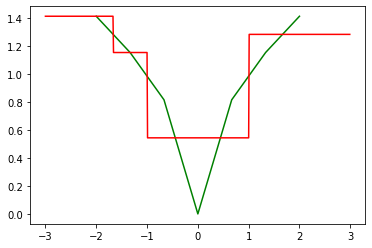

In [28]:
X = np.linspace(-2, 2, 7)
X = np.sort(np.concatenate((X, X, X, X)))
y = np.abs(X) ** 0.5
X = X.reshape(-1, 1)
print(X.shape)
print(y.shape)

decisionTree = DecisionTree(max_depth = 2, criterion = variance, prediction = interpolate)
decisionTree.fit(X, y)
print(decisionTree)

aaa = np.arange(-3, 3, 0.01).reshape((-1, 1))
predicted = decisionTree.predict(aaa)

plt.plot(X, y, 'g', aaa, predicted, 'r')

## Тестирование реализованного алгоритма

### Классификация

С помощью метода `load_digits` загрузите датасет `digits`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие решающие деревья и убедитесь, что критерии gini и entropy дают разные результаты.

In [29]:
X, y = load_digits(return_X_y = True)
X = np.array(X)
y = np.array(y)
print(X, X.shape)
print(y, y.shape)
print()

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 17)
print(train_X, train_X.shape)
print(test_X, test_X.shape)
print()
print(train_y, train_y.shape)
print(test_y, test_y.shape)
print()

[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]] (1797, 64)
[0 1 2 ... 8 9 8] (1797,)

[[ 0.  0.  3. ... 16.  2.  0.]
 [ 0.  0.  6. ...  0.  0.  0.]
 [ 0.  1.  7. ...  0.  0.  0.]
 ...
 [ 0.  6. 16. ... 11.  1.  0.]
 [ 0.  1.  8. ...  0.  0.  0.]
 [ 0.  0.  0. ... 16. 16. 16.]] (1437, 64)
[[ 0.  0.  0. ...  6.  0.  0.]
 [ 0.  0.  0. ... 14.  4.  0.]
 [ 0.  0.  5. ...  0.  0.  0.]
 ...
 [ 0.  0.  2. ... 15.  4.  0.]
 [ 0.  0.  4. ...  6.  0.  0.]
 [ 0.  0. 13. ...  0.  0.  0.]] (360, 64)

[1 9 5 ... 3 7 1] (1437,)
[1 2 7 3 9 5 8 9 8 1 4 3 5 0 9 9 5 3 9 6 6 3 6 4 6 2 6 7 3 1 8 4 1 1 0 2 3
 5 5 5 5 6 0 5 3 5 1 8 2 9 9 4 0 8 8 1 1 1 0 4 1 2 0 7 9 8 8 6 0 8 8 3 4 6
 4 3 2 3 9 7 5 8 3 5 1 8 9 5 4 7 7 8 3 0 2 7 9 9 4 0 5 6 4 0 1 3 3 1 8 7 4
 2 5 5 3 9 6 4 2 7 4 1 8 5 1 5 8 6 5 5 4 9 4 2 7 8 4 4 4 9 7 1 9 9 2 0 0 3
 5 8 1 9 5 3 6 8 7 4 6 1 9 7 6 4 0 9 4

С помощью 5-кратной кросс-валидации (`GridSearchCV`) подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - range(3, 11), а для criterion - {'gini', 'entropy'}. Критерий качества `scoring`='accuracy'.

In [30]:
from sklearn.tree import DecisionTreeClassifier

tree_params = {'max_depth': list(range(3, 11)), 'criterion': ['gini', 'entropy']}

decisionTree = DecisionTreeClassifier()
tree_grid = GridSearchCV(decisionTree, tree_params, cv = 5, n_jobs = -1,
                         verbose = True, scoring = 'accuracy')
tree_grid.fit(train_X, train_y)
print('best parameters: {0}'.format(tree_grid.best_params_))
print('best score: {0}'.format(tree_grid.best_score_))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best parameters: {'criterion': 'entropy', 'max_depth': 10}
best score: 0.8677800974251914


[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    2.1s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [31]:
tree_params = {'max_depth': list(range(3, 11)), 'criterion': [gini, entropy]}

decisionTree = DecisionTree(prediction = classify)
tree_grid = GridSearchCV(decisionTree, tree_params, cv = 5, n_jobs = -1,
                         verbose = True, scoring = 'accuracy')
tree_grid.fit(train_X, train_y)
print('best parameters: {0}'.format(tree_grid.best_params_))
print('best score: {0}'.format(tree_grid.best_score_))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.5min finished


best parameters: {'criterion': <function entropy at 0x000001E8D3D99318>, 'max_depth': 9}
best score: 0.8615170494084899


Постройте графики средних значений критерия качества `accuracy` для критериев `gini` и `entropy` в зависимости от `max_depth`.

gini 0.3862212943632568
entropy 0.38761308281141266


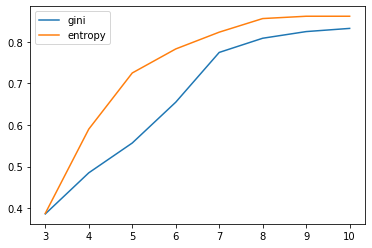

In [32]:
depths = [params['max_depth'] for params in tree_grid.cv_results_['params']]
criterions = [params['criterion'] for params in tree_grid.cv_results_['params']]
scores = np.array(tree_grid.cv_results_['mean_test_score'])

separated_depths = {}
separated_scores = {}
for depth, criterion, score in zip(depths, criterions, scores):
    criterion = criterion.__name__
    if criterion not in separated_depths:
        separated_depths[criterion] = list()
        separated_scores[criterion] = list()
    separated_depths[criterion].append(depth)
    separated_scores[criterion].append(score)
for criterion in separated_depths:
    rearrange = np.argsort(separated_depths[criterion])
    separated_depths[criterion] = np.array(separated_depths[criterion])[rearrange]
    separated_scores[criterion] = np.array(separated_scores[criterion])[rearrange]

for criterion in separated_depths:
    print(criterion, separated_scores[criterion][0])
    plt.plot(separated_depths[criterion], separated_scores[criterion])
plt.legend(separated_depths.keys())
pass

**Выберите верные утверждения:**
1. Оптимальное значение `max_depth` для каждого критерия достигается на отрезке [4, 9]. +
2. На отрезке [3, 10] построенные графики не пересекаются. +
3. На отрезке [3, 10] построенные графики пересекаются ровно один раз. -
4. Наилучшее качество при `max_depth` на интервале [3, 10] достигается при использовании критерия `gini`. -
5. Хотя бы для одного из критериев значение accuracy строго возрастает с ростом значения `max_depth` на интервале [3, 10]. ?

**Чему равны найденные оптимальные значения параметров max_depth и criterion?**
1. max_depth = 7, criterion = 'gini';
2. max_depth = 7, criterion = 'entropy';
3. max_depth = 10, criterion = 'entropy';
4. max_depth = 10, criterion = 'gini';
5. max_depth = 9, criterion = 'entropy'; <---
6. max_depth = 9, criterion = 'gini';

Используя найденные оптимальные значения max_depth и criterion, обучите решающее дерево на X_train, y_train и вычислите вероятности принадлежности к классам для X_test.

In [33]:
decisionTree = DecisionTree(max_depth = 9, criterion = entropy)
decisionTree.fit(train_X, train_y)
predicted = decisionTree.predict_proba(test_X)
print(predicted, predicted.shape)
print()

predicted = np.mean(predicted, axis = 0)
print(predicted, predicted.shape)
print(np.max(predicted))

[[0.         0.95652174 0.         ... 0.         0.04347826 0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 1.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 1.         0.         0.        ]] (360, 10)

[0.09166667 0.06986715 0.10648148 0.08981481 0.125      0.12083333
 0.07777778 0.09398148 0.11022544 0.11435185] (10,)
0.125


Для полученной матрицы вычислите усредненные по всем объектам из `X_test` значения вероятностей принадлежности к классам.

**Вопрос:** Чему примерно равна максимальная вероятность в полученном векторе?
1. 0.127 <---
2. 0.118
3. 1.0
4. 0.09

### Регрессия

С помощью метода `load_boston` загрузите датасет `boston`. Разделите выборку на обучающую и тестовую с помощью метода `train_test_split`, используйте значения параметров `test_size=0.2`, `random_state=17`. Попробуйте обучить неглубокие регрессионные деревья и убедитесь, что критерии `variance` и `mad_median` дают разные результаты.

In [34]:
X, y = load_boston(return_X_y = True)
X = np.array(X)
y = np.array(y)
print(X, X.shape)
print(y, y.shape)
print()

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.2, random_state = 17)
print(train_X, train_X.shape)
print(test_X, test_X.shape)
print()
print(train_y, train_y.shape)
print(test_y, test_y.shape)
print()

[[6.3200e-03 1.8000e+01 2.3100e+00 ... 1.5300e+01 3.9690e+02 4.9800e+00]
 [2.7310e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9690e+02 9.1400e+00]
 [2.7290e-02 0.0000e+00 7.0700e+00 ... 1.7800e+01 3.9283e+02 4.0300e+00]
 ...
 [6.0760e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 5.6400e+00]
 [1.0959e-01 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9345e+02 6.4800e+00]
 [4.7410e-02 0.0000e+00 1.1930e+01 ... 2.1000e+01 3.9690e+02 7.8800e+00]] (506, 13)
[24.  21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 15.  18.9 21.7 20.4
 18.2 19.9 23.1 17.5 20.2 18.2 13.6 19.6 15.2 14.5 15.6 13.9 16.6 14.8
 18.4 21.  12.7 14.5 13.2 13.1 13.5 18.9 20.  21.  24.7 30.8 34.9 26.6
 25.3 24.7 21.2 19.3 20.  16.6 14.4 19.4 19.7 20.5 25.  23.4 18.9 35.4
 24.7 31.6 23.3 19.6 18.7 16.  22.2 25.  33.  23.5 19.4 22.  17.4 20.9
 24.2 21.7 22.8 23.4 24.1 21.4 20.  20.8 21.2 20.3 28.  23.9 24.8 22.9
 23.9 26.6 22.5 22.2 23.6 28.7 22.6 22.  22.9 25.  20.6 28.4 21.4 38.7
 43.8 33.2 27.5 26.5 18.6 19.3 20.1 19.5 19.5 20.

С помощью 5-кратной кросс-валидации подберите оптимальное значение параметров `max_depth` и `criterion`. Для параметра `max_depth` используйте диапазон значений - `range(2, 9)`, а для `criterion` - {'variance', 'mad_median'}. Критерий качества `scoring`='neg_mean_squared_error'.

In [35]:
from sklearn.tree import DecisionTreeRegressor

tree_params = {'max_depth': list(range(2, 9)), 'criterion': ['mse', 'mae']}

decisionTree = DecisionTreeRegressor()
tree_grid = GridSearchCV(decisionTree, tree_params, cv = 5, n_jobs = -1,
                         verbose = True, scoring = 'neg_mean_squared_error')
tree_grid.fit(train_X, train_y)
print('best parameters: {0}'.format(tree_grid.best_params_))
print('best score: {0}'.format(tree_grid.best_score_))

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


best parameters: {'criterion': 'mse', 'max_depth': 6}
best score: -20.60069106950041


[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:    0.2s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [36]:
tree_params = {'max_depth': list(range(2, 9)), 'criterion': [variance, mad_median]}

decisionTree = DecisionTree(prediction = interpolate)
tree_grid = GridSearchCV(decisionTree, tree_params, cv = 5, n_jobs = -1,
                         verbose = True, scoring = 'neg_mean_squared_error')
tree_grid.fit(train_X, train_y)
print('best parameters: {0}'.format(tree_grid.best_params_))
print('best score: {0}'.format(tree_grid.best_score_))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   25.0s finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best parameters: {'criterion': <function variance at 0x000001E8D3D99798>, 'max_depth': 5}
best score: -21.36953850891086


Постройте графики средних значений критерия качества `neg_mean_squared_error` для критериев `variance` и `mad_median` в зависимости от `max_depth`.

variance -32.54446911516344
mad_median -32.53603409983818


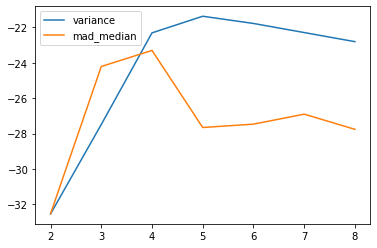

In [37]:
depths = [params['max_depth'] for params in tree_grid.cv_results_['params']]
criterions = [params['criterion'] for params in tree_grid.cv_results_['params']]
scores = np.array(tree_grid.cv_results_['mean_test_score'])

separated_depths = {}
separated_scores = {}
for depth, criterion, score in zip(depths, criterions, scores):
    criterion = criterion.__name__
    if criterion not in separated_depths:
        separated_depths[criterion] = list()
        separated_scores[criterion] = list()
    separated_depths[criterion].append(depth)
    separated_scores[criterion].append(score)
for criterion in separated_depths:
    rearrange = np.argsort(separated_depths[criterion])
    separated_depths[criterion] = np.array(separated_depths[criterion])[rearrange]
    separated_scores[criterion] = np.array(separated_scores[criterion])[rearrange]

for criterion in separated_depths:
    print(criterion, separated_scores[criterion][0])
    plt.plot(separated_depths[criterion], separated_scores[criterion])
plt.legend(separated_depths.keys())
pass

**Выберите верные утверждения:**
1. На отрезке [2, 8] построенные графики не пересекаются. -
2. На отрезке [2, 8] построенные графики пересекаются ровно один раз. ?
3. Оптимальное значение `max_depth` для каждого из критериев достигается на границе отрезка [2, 8]. -
4. Наилучшее качество при `max_depth` из [2, 8] достигается при использовании критерия `mad_median`. -

**Чему равны найденные оптимальные значения параметров `max_depth` и `criterion`?**
1. max_depth = 9, criterion = 'variance';
2. max_depth = 5, criterion = 'mad_median';
3. max_depth = 4, criterion = 'variance';
4. max_depth = 2, criterion = 'mad_median';
5. max_depth = 4, criterion = 'mad_median';
6. max_depth = 5, criterion = 'variance'; <---